In [15]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService


from numpy import sin, cos
import numpy as np

from itertools import product

import random

import json

service = QiskitRuntimeService()
BACKEND = service.backend("ibm_osaka")
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=3)
estimator = Estimator(backend=BACKEND)
# estimator = Estimator(backend=AerSimulator())

env: QXToken=a7fcc7473249a012e25a2fcd2d707e1bad0147347980ee262685115c42e30b7410dbc887e039a23266c21997a4accb5f3b8669d952a2a75d4d80d0c360d130a0


In [ ]:
#fname = 'lab4_jobs_id.json'
#with open(fname, 'w') as file:
#    json.dump(all_z_obs_jobs, file)

In [3]:
def get_hamiltonian(N, J, U, h):

    tuples_1 = [("XX", [i, i + 1], -J) for i in range(0, N - 1)]
    tuples_2 = [("YY", [i, i + 1], -J) for i in range(0, N - 1)]
    tuples_3 = [("ZZ", [i, i + 1], U) for i in range(0, N - 1)]
    tuples_4 = [("Z", [i], h[i]) for i in range(0, N)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*tuples_1, *tuples_2, *tuples_3, *tuples_4], num_qubits=N)
    return hamiltonian.simplify()

In [4]:
def get_hamiltonian_v2(N, J, U, h):

    lattice_map = CouplingMap.from_line(N, bidirectional=False)

    edgelist = lattice_map.graph.edge_list()
    hamlist = []

    for edge in edgelist:
        hamlist.append(("XX", edge, -J))
        hamlist.append(("YY", edge, -J))
        hamlist.append(("ZZ", edge, U))

    for i, qubit in enumerate(lattice_map.physical_qubits):
        hamlist.append(("Z", [qubit], h[i]))

    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=N)
        
    return hamiltonian.simplify()

In [5]:
def get_hamiltonian_basic(N, J, U, h):

    lattice_map = CouplingMap.from_line(N, bidirectional=False)

    edgelist = lattice_map.graph.edge_list()
    hamlist = []
    hamlist_odd = []

    for edge in edgelist:
        if edge[0] % 2 == 0:
            hamlist.append(("XX", edge, -J))
            hamlist.append(("YY", edge, -J))
            hamlist.append(("ZZ", edge, U))
        else:
            hamlist_odd.append(("XX", edge, -J))
            hamlist_odd.append(("YY", edge, -J))
            hamlist_odd.append(("ZZ", edge, U))

    hamlist += hamlist_odd
    
    for i, qubit in enumerate(lattice_map.physical_qubits):
        hamlist.append(("Z", [qubit], h[i]))

    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=N)
        
    return hamiltonian.simplify()

In [6]:
def get_hamiltonian_symmetric(N, J, U, h):

    lattice_map = CouplingMap.from_line(N, bidirectional=False)

    edgelist = lattice_map.graph.edge_list()
    hamlist_single = []
    hamlist_even = []
    hamlist_odd = []

    for i, qubit in enumerate(lattice_map.physical_qubits):
        hamlist_single.append(("Z", [qubit], h[i] * 0.5))

    for edge in edgelist:
        if edge[0] % 2 == 0:
            hamlist_even.append(("XX", edge, -J))
            hamlist_even.append(("YY", edge, -J))
            hamlist_even.append(("ZZ", edge, U))
        else:
            hamlist_odd.append(("XX", edge, -J * 0.5))
            hamlist_odd.append(("YY", edge, -J * 0.5))
            hamlist_odd.append(("ZZ", edge, U * 0.5))

    hamlist = hamlist_single + hamlist_odd + hamlist_even + hamlist_odd + hamlist_single
    
    #for i, qubit in enumerate(lattice_map.physical_qubits):
    #    hamlist.append(("Z", [qubit], h[i]))

    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=N)
        
    return hamiltonian.simplify()

In [7]:
def magnetization_ops(qubit, N):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

def Nhalf_obs(N):
    lattice_map = CouplingMap.from_line(N, bidirectional=False)

    obs_list = []
    for qubit in lattice_map.physical_qubits[0:int(N/2)]:
        obs_list.append(("Z", [qubit], 0.5))
        obs_list.append(("I", [qubit], 0.5))

    observable = SparsePauliOp.from_sparse_list(obs_list, num_qubits=N)
    return observable


# estimator = Estimator(backend=AerSimulator())
def Nhalf_value(N, circ):
    lattice_map = CouplingMap.from_line(N, bidirectional=False)

    Nhalf_value = 0
    for qubit in lattice_map.physical_qubits[0:int(N/2)]:
        obs = [("Z", [qubit], 0.5)] #the I gate will always just return 0.5 * 1 , ("I", [qubit], 0.5)
        observable = SparsePauliOp.from_sparse_list(obs, num_qubits=N)
        pub = (circ, observable)
        job = estimator.run([pub])
        results = job.result()

        Nhalf_value += results[0].data.evs + 0.5
    return Nhalf_value



def correlator(qubits: list, N, circ):
    
    obs2 = magnetization_ops(qubits[0], N)
    obs3 = magnetization_ops(qubits[1], N)

    if qubits[0] == qubits[1]: # if j and k refer to the same qubit, then ZZ=I
        pubs = [(circ, obs2), (circ, obs3)]
        job = estimator.run(pubs)
        results = job.result()

        correlator_value = 1 - (results[0].data.evs * results[1].data.evs)
    else:
        obs1 = SparsePauliOp.from_sparse_list([("ZZ", qubits, 1.0)], num_qubits=N)

        pubs = [(circ, obs1), (circ, obs2), (circ, obs3)]
        job = estimator.run(pubs)
        results = job.result()

        correlator_value = results[0].data.evs - (results[1].data.evs * results[2].data.evs)

    return correlator_value


def qfi(N, circ):
    s = [1 for _ in range(int(N/2))] + [-1 for _ in range(int(N/2))]

    obs_type1 = []
    extra_type1 = []
    for i, j in product(range(N), range(N)):
        if i == j: # ZZ = I on the same qubit
            extra_type1.append(s[i] * s[j])
        else:
            obs_type1.append(SparsePauliOp.from_sparse_list([("ZZ", [i, j], s[i] * s[j])], num_qubits=N))
    pubs = [(circ, obs) for obs in obs_type1]
    job_type1 = estimator.run(pubs)
    results_type1 = job_type1.result()

    obs_type2 = []
    for i in range(N):
        obs_type2.append(SparsePauliOp.from_sparse_list([("Z", [i], s[i])], num_qubits=N))
    pubs = [(circ, obs) for obs in obs_type2]
    job_type2 = estimator.run(pubs)
    results_type2 = job_type2.result()

    QFI = sum([results_type1[i].data.evs for i in range(N*N - N)] + extra_type1) - (sum(results_type2[i].data.evs for i in range(N))**2)

    return QFI


# Magnetization Density Plots (Fig 2)

### Checking Trotterization

In [8]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, LieTrotter

from tqdm.notebook import tqdm
from qiskit.primitives import Estimator

In [9]:
total_time = 2.5
nb_timesteps = 16
timesteps_duration = total_time/nb_timesteps

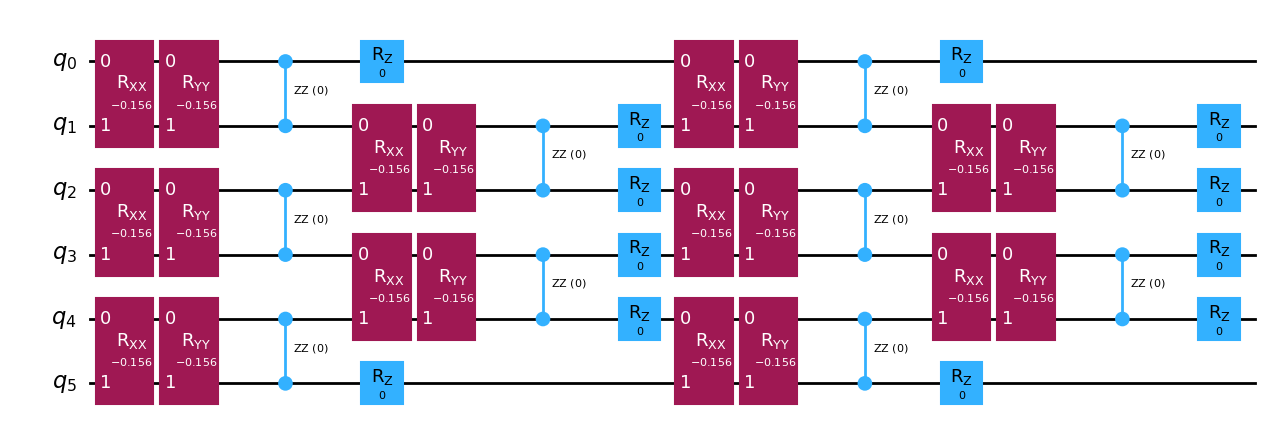

In [12]:
N = 6
H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=2)
circ = st.synthesize(gate)

circ.decompose().draw('mpl')


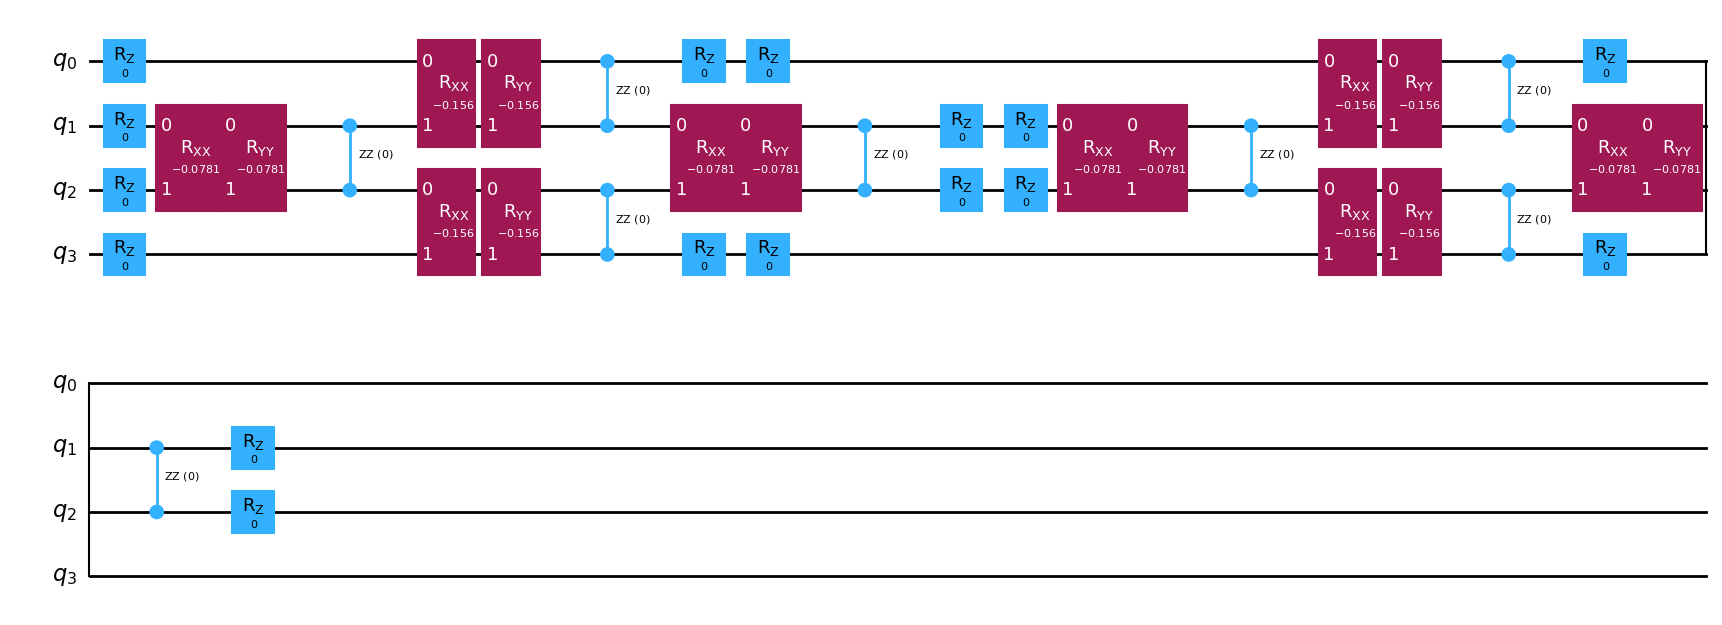

In [16]:
N = 4
H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=2)
circ = st.synthesize(gate)

circ.decompose().draw('mpl')
#pass_manager.run(circ).draw('mpl')

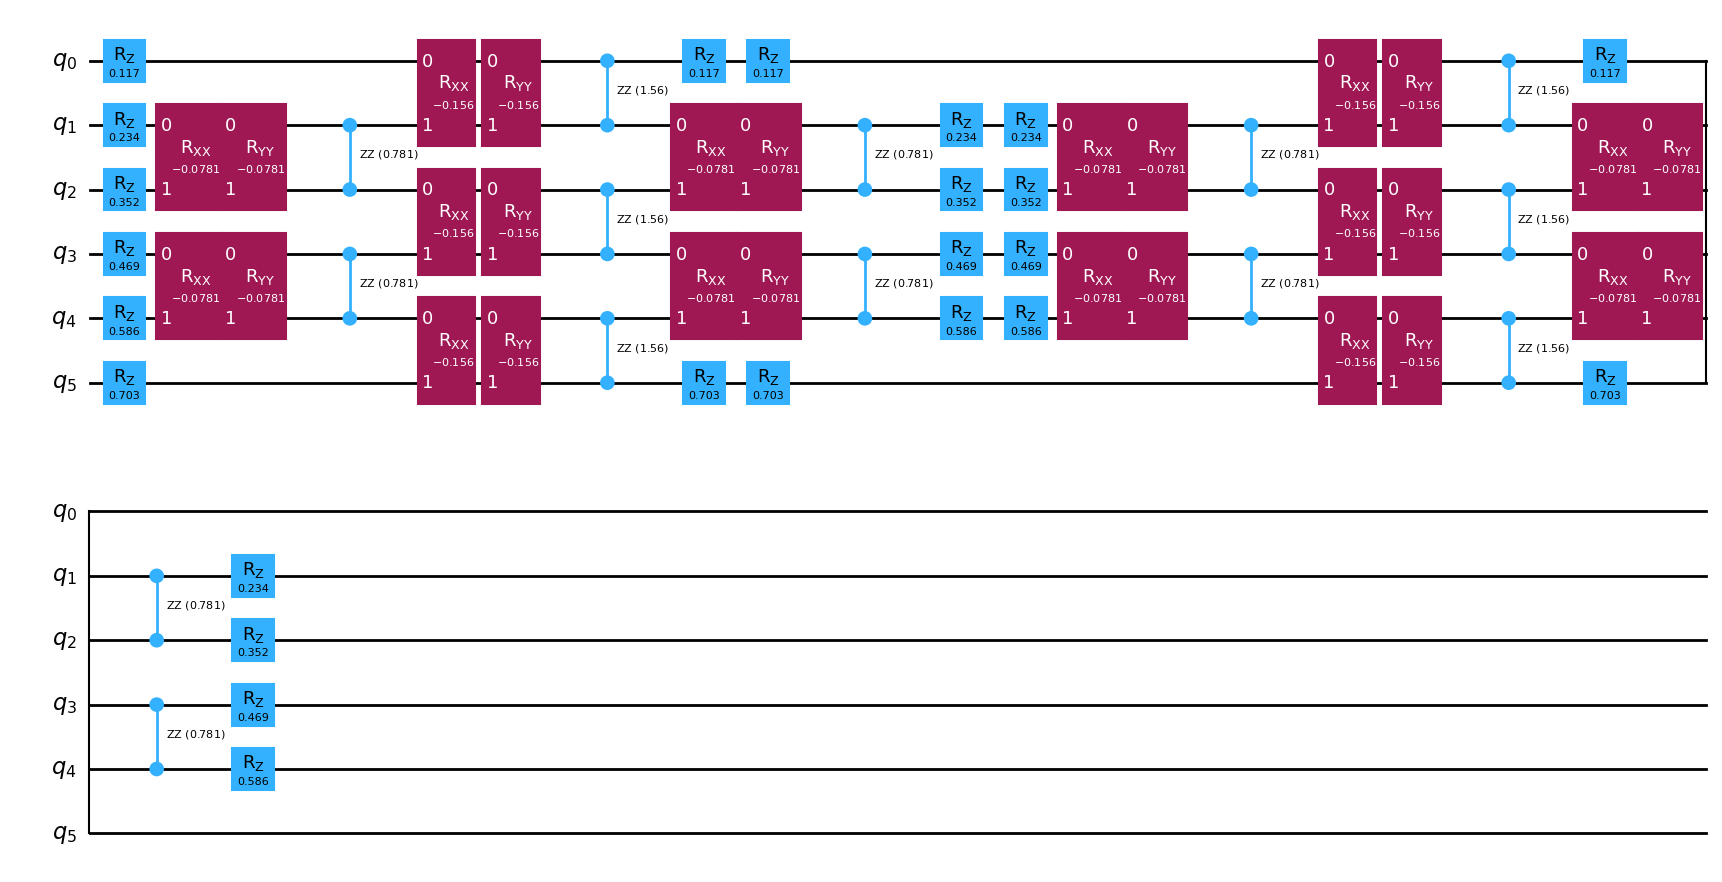

In [238]:
N = 6
H = get_hamiltonian_symmetric(N=N, J=1, U=10, h=[1.5 * (i+1) for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=2)
circ = st.synthesize(gate)

#circ.draw('mpl')
pass_manager.run(circ).draw('mpl')

### Fig 2 plots

In [17]:
N = 6
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=2)

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''

H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(127)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

jobs_dict = {}
# estimator = Estimator(backend=AerSimulator())
magnetization_density=[]
with Batch(backend=BACKEND) as batch:
    for i, circ in enumerate(tqdm(circuits)):

        #outputstate = Statevector(circ)
        pubs = [(circ, magnetization_ops(qubit, 127)) for qubit in range(N)]
        job = estimator.run(pubs)
        #id_dict[i] = job.job_id()
        
        jobs_dict[i] = job

        fname = 'magnetization_6_jobs_id.txt'
        with open(fname, 'a') as file:
            file.write("{" + str(i) + ":" + str(job.job_id()) + "}")
            file.write(', \n')

        #print([results[i].data.evs for i in range(N)])
        #mags=[results.values[i] for i in range(N)]
        #mags=[results[i].data.evs for i in range(N)]

        #magnetization_density.append(mags)



  0%|          | 0/17 [00:00<?, ?it/s]

IBMRuntimeError: 'Failed to run program: \'409 Client Error: Conflict for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"You have reached the limit of 3 pending  jobs. Please wait for a job to complete or cancel one before submitting anything new.","code":3458,"solution":"Wait until some previous jobs were finished. You can cancel pending jobs to run new jobs.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

Text(0, 0.5, 'Time (1/J)')

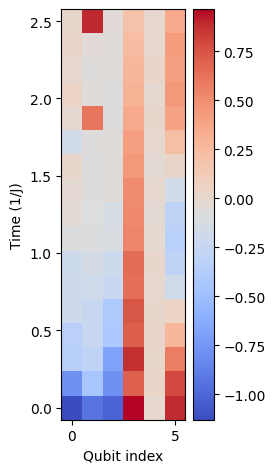

In [13]:
for i in jobs_dict:
    results = jobs_dict[i].result()
    mags = [results[i].data.evs for i in range(N)]
    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(6/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [29]:
N = 8
'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''
H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(127)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

jobs_dict = {}
# estimator = Estimator(backend=AerSimulator())
magnetization_density=[]
with Batch(backend=BACKEND) as batch:
    for i, circ in enumerate(tqdm(circuits)):

        #outputstate = Statevector(circ)
        pubs = [(circ, magnetization_ops(qubit, 127)) for qubit in range(N)]
        job = estimator.run(pubs)

        jobs_dict[i] = job

        fname = 'magnetization_8_jobs_id.txt'
        with open(fname, 'a') as file:
            file.write("{" + str(i) + ":" + str(job.job_id()) + "}")
            file.write(', \n')

        #results = job.result()
        #print([results[i].data.evs for i in range(N)])
        #mags=[results.values[i] for i in range(N)]
        #mags=[results[i].data.evs for i in range(N)]

        #magnetization_density.append(mags)


  0%|          | 0/17 [00:00<?, ?it/s]

AttributeError: 'RuntimeJobV2' object has no attribute 'results'

ctr5nt7907y0008wmw70
ctr5ntq6g3rg0087r7ng
ctr5nv76g3rg0087r7p0
ctr5nvq6g3rg0087r7pg
ctr5nvz6g3rg0087r7q0
ctr5nwf6g3rg0087r7qg
ctr5nx74gjh0008pvzn0


Text(0, 0.5, 'Time (1/J)')

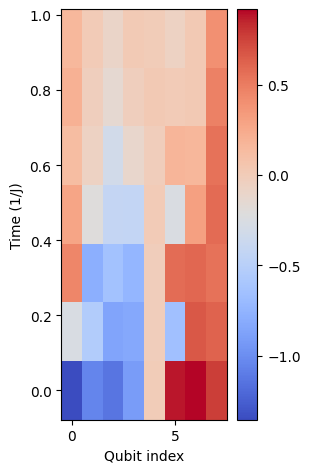

In [40]:
magnetization_density = []
for i in range(7): #jobs_dict:
    print(jobs_dict[i].job_id())
    results = jobs_dict[i].result()
    mags = [results[j].data.evs for j in range(N)]
    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(8/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(7)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

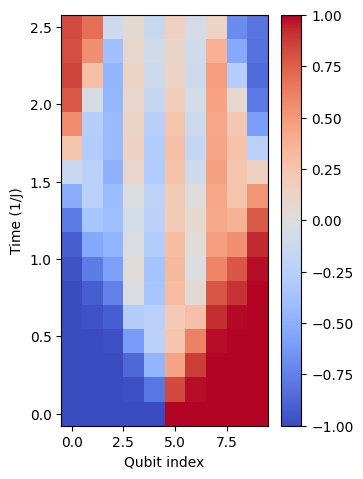

In [140]:
N = 10

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''

H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

jobs_dict = {}
# estimator = Estimator(backend=AerSimulator())
magnetization_density=[]
with Batch(backend=BACKEND) as batch:
    
    for i, circ in enumerate(tqdm(circuits)):

        pubs = [(circ, magnetization_ops(qubit, N)) for qubit in range(N)]
        job = estimator.run(pubs)
        jobs_dict[i] = job

        fname = 'magnetization_10_jobs_id.txt'
        with open(fname, 'a') as file:
            file.write("{" + str(i) + ":" + str(job.job_id()) + "}")
            file.write(', \n')

        #results = job.result()
        #print([results[i].data.evs for i in range(N)])
        #mags=[results.values[i] for i in range(N)]
        #mags=[results[i].data.evs for i in range(N)]

        #magnetization_density.append(mags)


for i in jobs_dict:
    results = jobs_dict[i].result()
    mags = [results[i].data.evs for i in range(N)]
    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(8/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(10/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

fname = 'magnetization_10_jobs_id.json'
with open(fname, 'w') as file:
    json.dump(id_dict, file)

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

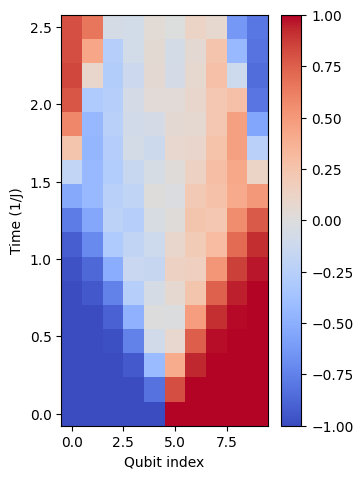

In [166]:
N = 10

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''

H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

jobs_dict = {}
# estimator = Estimator(backend=AerSimulator())
magnetization_density=[]
with Batch(backend=BACKEND) as batch:
    for i, circ in enumerate(tqdm(circuits)):

        #outputstate = Statevector(circ)
        pubs = [(circ, magnetization_ops(qubit, N)) for qubit in range(N)]
        job = estimator.run(pubs)

        fname = 'magnetization_10_sym_jobs_id.txt'
        with open(fname, 'a') as file:
            file.write("{" + str(i) + ":" + str(job.job_id()) + "}")
            file.write(', \n')


        results = job.result()
        #print([results[i].data.evs for i in range(N)])
        #mags=[results.values[i] for i in range(N)]
        mags=[results[i].data.evs for i in range(N)]

        magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(10/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')


In [247]:
N = 6

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''

H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

# estimator = Estimator(backend=AerSimulator())
magnetization_density_3=[]
magnetization_density_5=[]
for circ in tqdm(circuits):

    pubs = [(circ, magnetization_ops(qubit, N)) for qubit in [3, 5]]
    job = estimator.run(pubs)
    results = job.result()


    magnetization_density_3.append(results[0].data.evs)
    magnetization_density_5.append(results[1].data.evs)

magnetization_density_3=np.array(magnetization_density_3)
magnetization_density_5=np.array(magnetization_density_5)

fname = 'magnetization_time_jobs_id.json'
with open(fname, 'w') as file:
    json.dump(id_dict, file)

  0%|          | 0/17 [00:00<?, ?it/s]

In [248]:
total_time_long = 10
nb_timesteps_long = 64
timesteps_duration_long = total_time_long/nb_timesteps_long

N = 6

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration_long)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''


H = get_hamiltonian_basic(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps_long+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))


# estimator = Estimator(backend=AerSimulator())
magnetization_density_5_long=[]
for circ in tqdm(circuits):

    pubs = [(circ, magnetization_ops(5, N))]
    job = estimator.run(pubs)
    results = job.result()

    magnetization_density_5_long.append(results[0].data.evs)

magnetization_density_5_long=np.array(magnetization_density_5_long)



  0%|          | 0/65 [00:00<?, ?it/s]

Text(0, 0.5, 'Magnetization (on 4th qubit)')

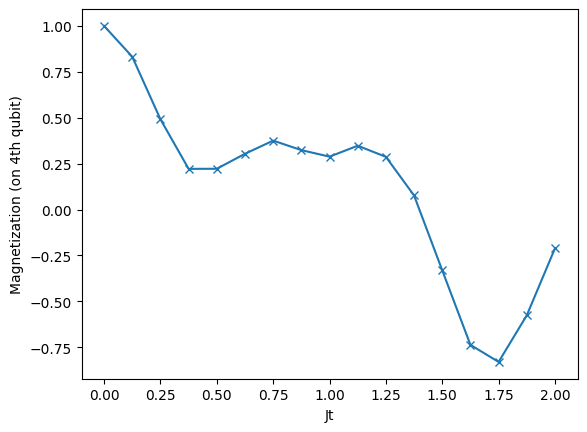

In [249]:
times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, magnetization_density_3, marker="x")
plt.xlabel('Jt')
plt.ylabel('Magnetization (on 4th qubit)')

Text(0, 0.5, 'Magnetization (on 6th qubit)')

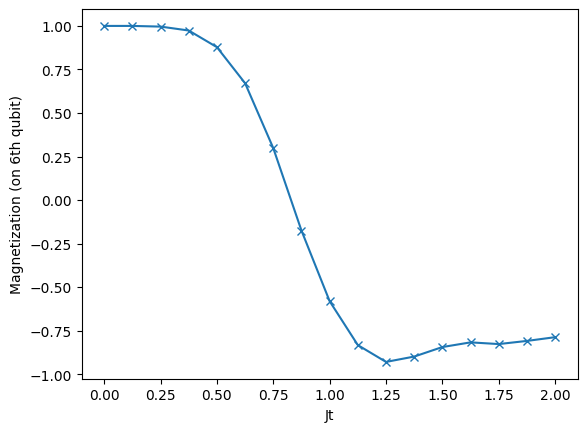

In [250]:
times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, magnetization_density_5, marker="x")
plt.xlabel('Jt')
plt.ylabel('Magnetization (on 6th qubit)')

Text(0, 0.5, 'Magnetization (on 6th qubit)')

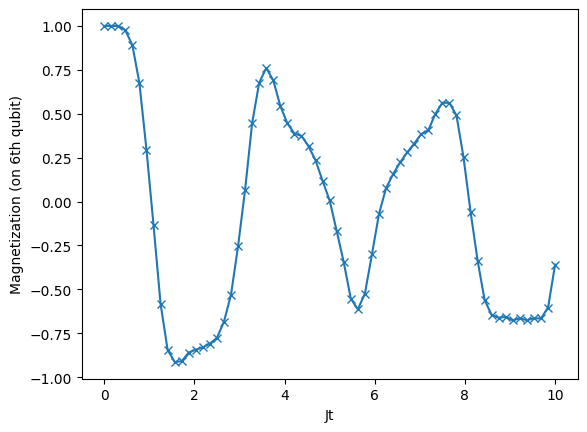

In [251]:
times_long = np.linspace(0, total_time_long, nb_timesteps_long + 1) 
plt.plot(times_long, magnetization_density_5_long, marker="x")
plt.xlabel('Jt')
plt.ylabel('Magnetization (on 6th qubit)')

# Nhalf Plots (Fig 3)

In [191]:
# estimator = Estimator(backend=AerSimulator())

def Nhalf_disorderedXX(h, N):
    #N = 6
    total_time = 2.5
    nb_timesteps = 16
    timesteps_duration = total_time/nb_timesteps

    h_values = [random.uniform(-h * 100, h * 100)/ 100 for _ in range(N)]
    H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=h_values)

    gate = PauliEvolutionGate(H, time=timesteps_duration)

    st = LieTrotter(reps=1)
    circ = st.synthesize(gate)

    gate = circ.to_instruction()

    circuits = []
    for n_steps in range(nb_timesteps+1):
        qc = QuantumCircuit(N,N)
        for i in range(int(N/2)):
            qc.x(i) 
        
        for _ in range(n_steps):
            qc.append(gate, [i for i in range(N)])

        circuits.append(pass_manager.run(qc))


    Nhalf=[]
    observable = Nhalf_obs(N)
    for circ in tqdm(circuits):
        pub = (circ, observable)
        job = estimator.run([pub])
        results = job.result()
        Nhalf.append(results[0].data.evs)

    Nhalf=np.array(Nhalf)
    return Nhalf

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Nhalf')

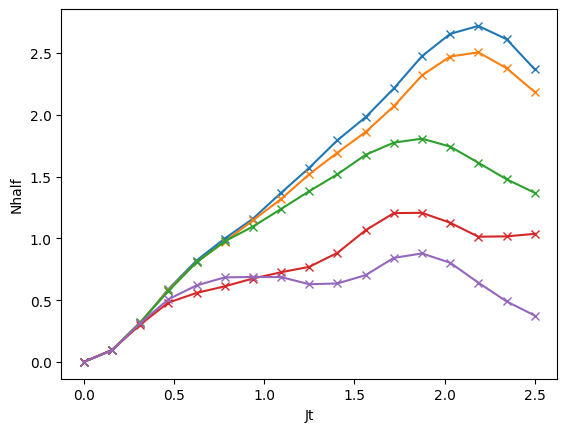

In [192]:
N = 6
total_time = 2.5
nb_timesteps = 16

times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, Nhalf_disorderedXX(0, N), marker="x")
plt.plot(times, Nhalf_disorderedXX(0.5, N), marker="x")
plt.plot(times, Nhalf_disorderedXX(1, N), marker="x")
plt.plot(times, Nhalf_disorderedXX(1.5, N), marker="x")
plt.plot(times, Nhalf_disorderedXX(2, N), marker="x")
plt.xlabel('Jt')
plt.ylabel('Nhalf')

In [206]:
# estimator = Estimator(backend=AerSimulator())

def Nhalf_XXZ(U, N):
    #N = 6
    total_time = 1.5
    nb_timesteps = 16
    timesteps_duration = total_time/nb_timesteps

    H = get_hamiltonian_basic(N=N, J=1, U=U, h=[0 for _ in range(N)])

    gate = PauliEvolutionGate(H, time=timesteps_duration)

    st = LieTrotter(reps=1)
    circ = st.synthesize(gate)

    gate = circ.to_instruction()

    circuits = []
    for n_steps in range(nb_timesteps+1):
        qc = QuantumCircuit(N,N)
        for i in range(int(N/2)):
            qc.x(i) 
        
        for _ in range(n_steps):
            qc.append(gate, [i for i in range(N)])

        circuits.append(pass_manager.run(qc))


    Nhalf=[]
    observable = Nhalf_obs(N)
    for circ in tqdm(circuits):
        pub = (circ, observable)
        job = estimator.run([pub])
        results = job.result()
        Nhalf.append(results[0].data.evs)

    Nhalf=np.array(Nhalf)
    return Nhalf

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Nhalf')

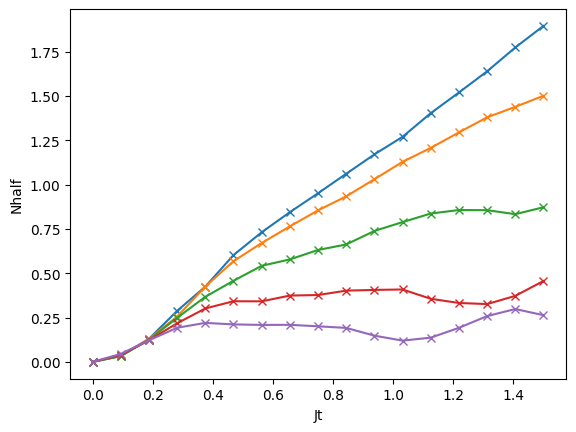

In [222]:
N = 6
total_time = 1.5
nb_timesteps = 16

times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, Nhalf_XXZ(0, N), marker="x")
plt.plot(times, Nhalf_XXZ(0.5, N), marker="x")
plt.plot(times, Nhalf_XXZ(1.0, N), marker="x")
plt.plot(times, Nhalf_XXZ(1.5, N), marker="x")
plt.plot(times, Nhalf_XXZ(2.0, N), marker="x")
plt.xlabel('Jt')
plt.ylabel('Nhalf')

In [244]:
# estimator = Estimator(backend=AerSimulator())

def Nhalf_XXZ_linear(U, N):
    #N = 6
    total_time = 2
    nb_timesteps = 16
    timesteps_duration = total_time/nb_timesteps

    H = get_hamiltonian_symmetric(N=N, J=1, U=U, h=[1.5 * (i+1) for i in range(N)])

    gate = PauliEvolutionGate(H, time=timesteps_duration)

    st = LieTrotter(reps=1)
    circ = st.synthesize(gate)

    gate = circ.to_instruction()

    circuits = []
    for n_steps in range(nb_timesteps+1):
        qc = QuantumCircuit(N,N)
        for i in range(int(N/2)):
            qc.x(i) 
        
        for _ in range(n_steps):
            qc.append(gate, [i for i in range(N)])

        circuits.append(pass_manager.run(qc))


    Nhalf=[]
    for circ in tqdm(circuits):
        Nhalf.append(Nhalf_value(N, circ))

    Nhalf=np.array(Nhalf)
    return Nhalf

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Nhalf')

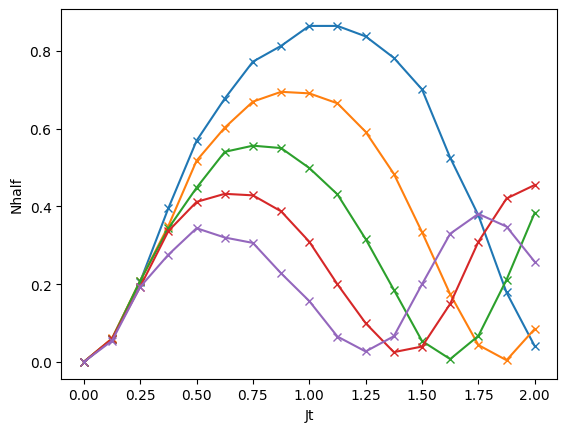

In [245]:
N = 16
total_time = 2
nb_timesteps = 16

times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, Nhalf_XXZ_linear(0, N), marker="x")
plt.plot(times, Nhalf_XXZ_linear(0.2, N), marker="x")
plt.plot(times, Nhalf_XXZ_linear(0.4, N), marker="x")
plt.plot(times, Nhalf_XXZ_linear(0.6, N), marker="x")
plt.plot(times, Nhalf_XXZ_linear(0.8, N), marker="x")
plt.xlabel('Jt')
plt.ylabel('Nhalf')

# Spin correlator

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Jt')

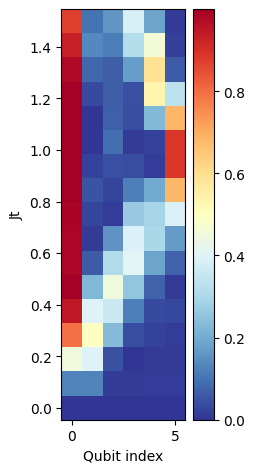

In [167]:
N = 6
total_time_short = 1.5
nb_timesteps_short = 16
timesteps_duration_short = total_time_short/nb_timesteps_short

'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''

H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=[0 for _ in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration_short)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps_short+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i*2) # neel state = antiferromagnet, apparently CDW can arise im antiferromagnet states??
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

# estimator = Estimator(backend=AerSimulator())
correlators_density=[]
for circ in tqdm(circuits):

    correlators = [abs(correlator([0, i], N, circ)) for i in range(N)] #absolute value because it is correlator??
    correlators_density.append(correlators)

correlators_density=np.array(correlators_density)

fig = plt.figure(figsize=(6/3,16/3), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration_short * i for i in range(nb_timesteps_short+1)], correlators_density, cmap='RdYlBu_r')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Jt')

# Fig 5: QFI

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'F/N')

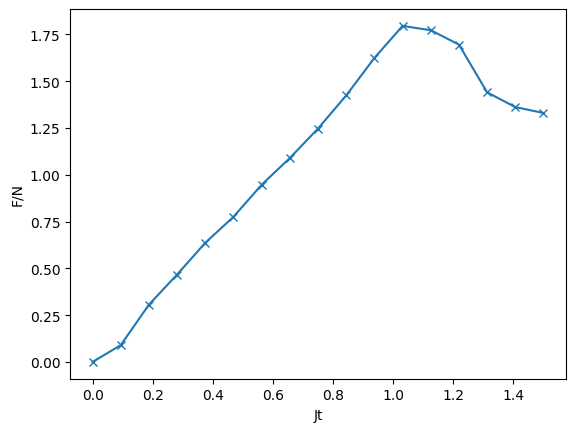

In [252]:
N = 6
total_time_short = 1.5
nb_timesteps_short = 16
timesteps_duration_short = total_time_short/nb_timesteps_short
'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''
H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration_short)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps_short+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i*2)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

# estimator = Estimator(backend=AerSimulator())
qfi_list=[]
for circ in tqdm(circuits):

    qfi_list.append(qfi(N, circ))

qfi_plot = 1/N * np.array(qfi_list)
times = np.linspace(0, total_time_short, nb_timesteps_short + 1) 
plt.plot(times, qfi_plot, marker="x")
plt.xlabel('Jt')
plt.ylabel('F/N')

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'F/N')

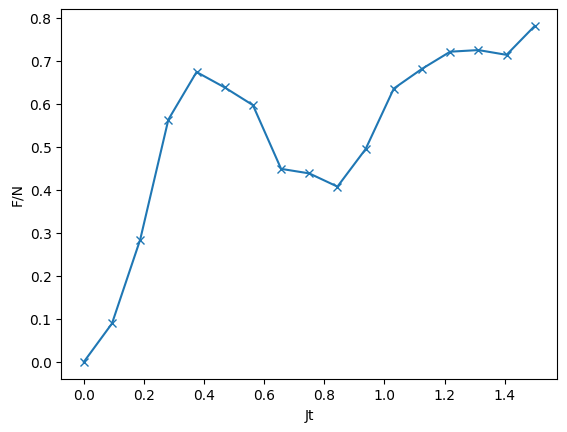

In [168]:
N = 6
total_time_short = 1.5
nb_timesteps_short = 16
timesteps_duration_short = total_time_short/nb_timesteps_short
'''
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)
'''
H = get_hamiltonian_symmetric(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration_short)

st = LieTrotter(reps=1)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps_short+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(pass_manager.run(qc))

# estimator = Estimator(backend=AerSimulator())
qfi_list=[]
for circ in tqdm(circuits):

    qfi_list.append(qfi(N, circ))

qfi_plot = 1/N * np.array(qfi_list)
times = np.linspace(0, total_time_short, nb_timesteps_short + 1) 
plt.plot(times, qfi_plot, marker="x")
plt.xlabel('Jt')
plt.ylabel('F/N')

# Using deprecated Qiskit_Algorithms.time_evolvers (Suzuki Trotter)

In [52]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [100]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [108]:
from qiskit_algorithms.time_evolvers import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(SuzukiTrotter(order=4, reps=5), num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

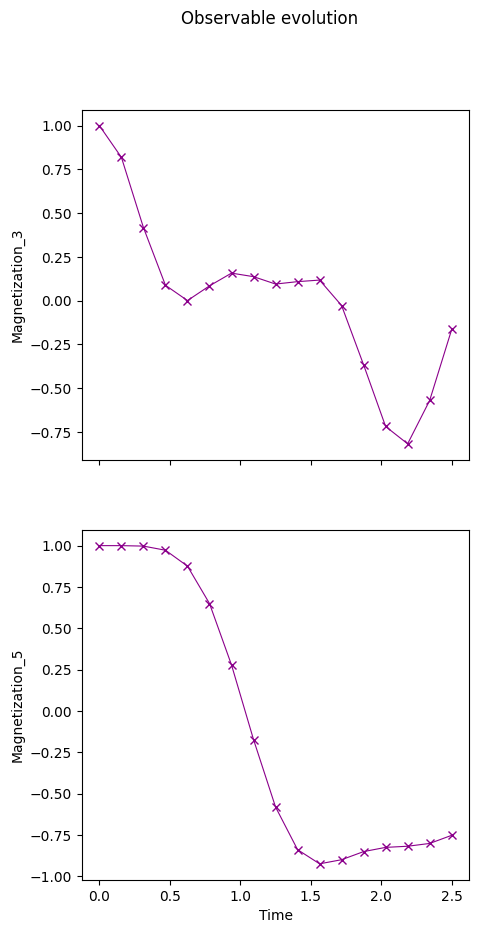

In [107]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

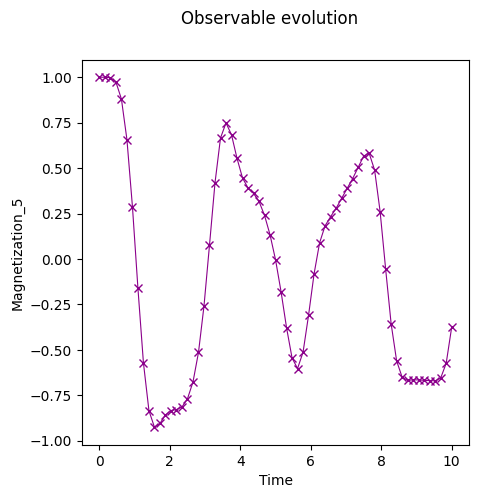

In [103]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Using deprecated Qiskit_Algorithms (Suzuki Trotter)

In [93]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [94]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [95]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

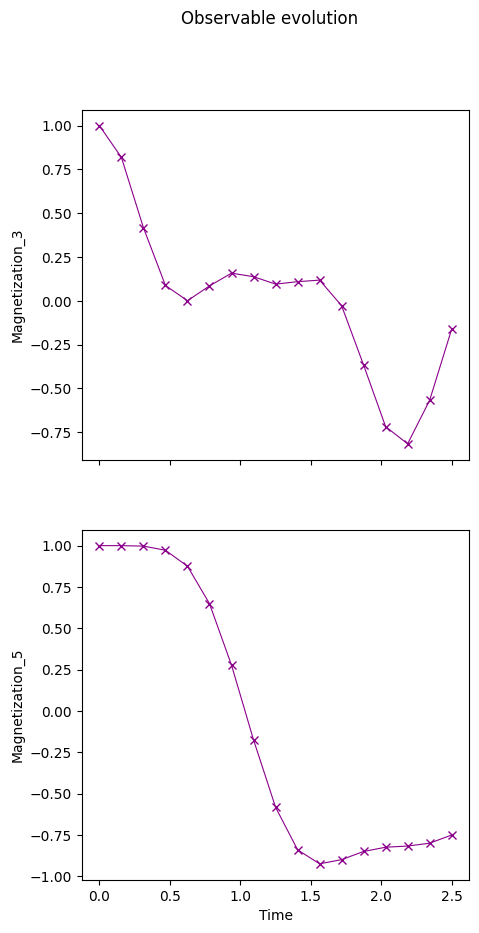

In [96]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

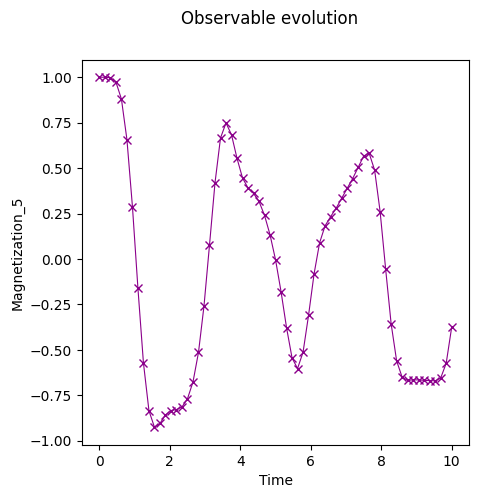

In [98]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Using deprecated Qiskit_Algorithms (Lie Trotter)


In [70]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [79]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [88]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

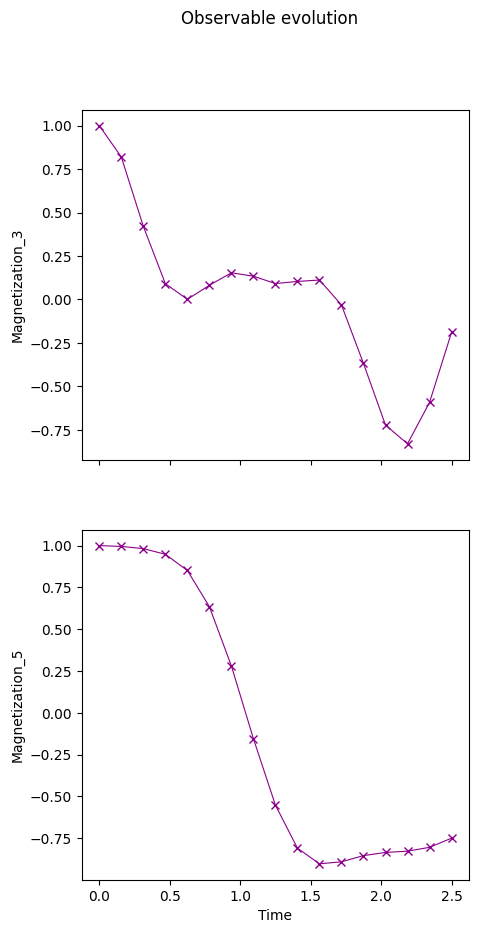

In [89]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

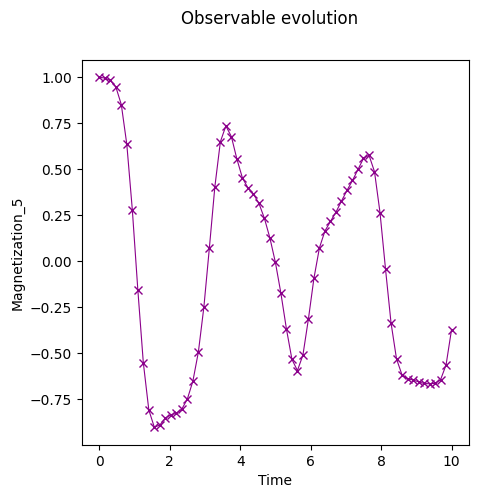

In [92]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Code from Online

In [4]:
def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [17]:
from math import pi

H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [18]:
from qiskit.circuit.library import PauliEvolutionGate

gate = PauliEvolutionGate(H)

In [22]:
from qiskit.synthesis import SuzukiTrotter

st = SuzukiTrotter(order=2, reps=2)
circ = st.synthesize(gate)

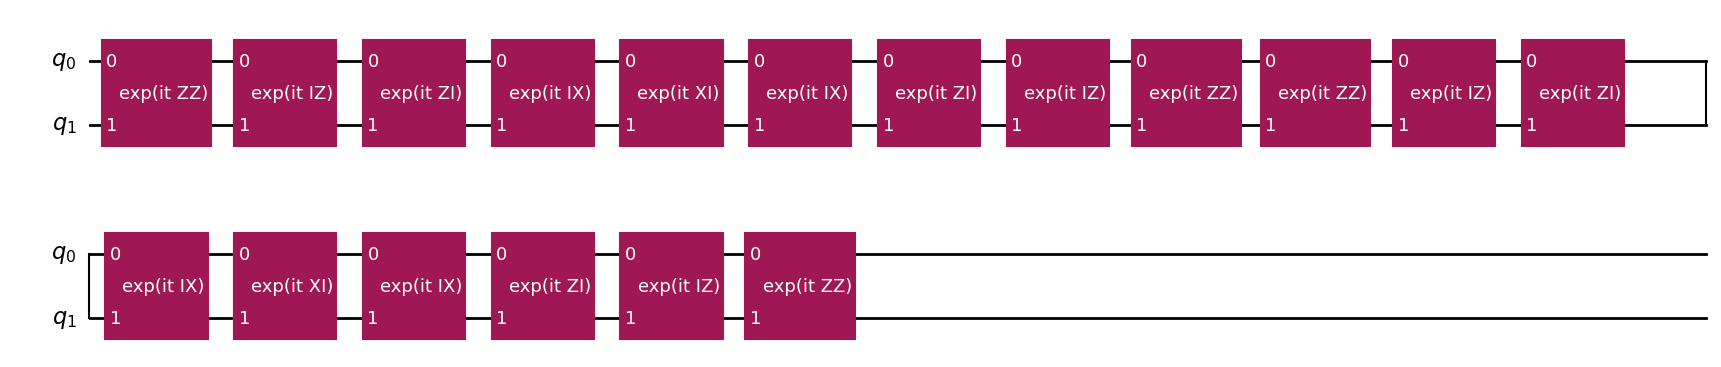

In [23]:
circ.draw('mpl')

In [7]:
%pip install qiskit_algorithms

  Obtaining dependency information for qiskit_algorithms from https://files.pythonhosted.org/packages/e0/2f/9a71fc36ff8de0188d4325399e1ad29c8fce2c2b427dae6c900003510943/qiskit_algorithms-0.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 7.3 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

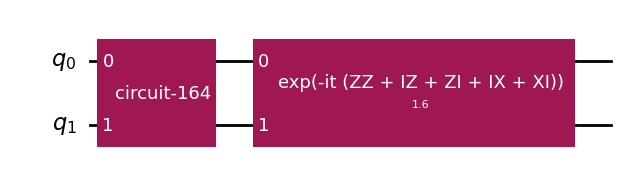

In [10]:
result.evolved_state.draw("mpl")

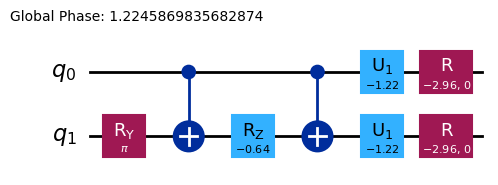

In [15]:
result.evolved_state.decompose(reps=3).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

In [16]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))
